# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
timestr = time.strftime("%Y%m%d")

# Import Data

In [2]:
#Import Colorcode
df_colors = pd.read_csv('.//for_paper//colors//df_colors.csv', index_col=0)
dict_colors = pd.DataFrame.to_dict(df_colors)['0']

In [3]:
#import datasets
zd = '2020_01'
df_dev_all = pd.read_csv('.//for_paper//df_overview//df_dev_'+zd+'_final_names.csv', decimal=',', sep=';', index_col=0)
df_dev_wo_can = df_dev_all[df_dev_all['Status']!='Cancelled']
df_dev_2015_onwards_wo_can = df_dev_wo_can[(df_dev_wo_can['Year']>=2015) | (df_dev_wo_can['Year']==0)]
df_dev = df_dev_2015_onwards_wo_can.copy()

zf = '2012_2019'
df_fin = pd.read_csv('.//for_paper//df_overview//df_fin_'+zf+'_final_names.csv', decimal=',', sep=';', index_col=0)


zi = '2019' 
df_inv = pd.read_csv('.//for_paper//df_overview//df_inv_'+zi+'_final_names.csv', decimal=',', sep=';', index_col=0)

c:\users\mann\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,14,15,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# create dataframes

In [4]:
#create individual dfs for loans & udnerwriting
df_loans = df_fin[df_fin['Type of Financing (short)']== 'Loans'].reset_index(drop=True)
df_under = df_fin[df_fin['Type of Financing (short)']== 'Underwriting'].reset_index(drop=True)

In [5]:
#create one df combining loans&underwriting and bond&shareholding, so including all relevant financing!
df_finv = df_inv.copy()
df_finv.rename(columns={'Type of financing (short)':'Type of Financing (short)', 'Share Total':'Grand Total', \
                       'INV':'FIN', 'INV Country':'FIN Country', 'INV Region':'FIN Region', \
                       'INV Annex 1':'FIN Annex 1'}, inplace=True)
df_finv = pd.concat((df_finv,df_fin))

In [6]:
#rename columns in df_inv
df_inv = df_inv.rename(columns={'Share Total':'Grand Total'})

# Overview of Data

In [7]:
#create dev dataset only with the DEV from the 4 different fin
df_dev_loans = df_dev[df_dev['DEV'].isin(set(df_loans['DEV']))]
df_dev_under = df_dev[df_dev['DEV'].isin(set(df_under['DEV']))]
df_dev_fin = df_dev[df_dev['DEV'].isin(set(df_fin['DEV']))]
df_dev_inv = df_dev[df_dev['DEV'].isin(set(df_inv['DEV']))]
df_dev_finv = df_dev[df_dev['DEV'].isin(set(df_finv['DEV']))]

In [8]:
#create the fin datasets only with the DEV from the dev dataset for each fin
df_loans_dev = df_loans[df_loans['DEV'].isin(set(df_dev_loans['DEV']))]
df_under_dev = df_under[df_under['DEV'].isin(set(df_dev_under['DEV']))]
df_fin_dev = df_fin[df_fin['DEV'].isin(set(df_dev_fin['DEV']))]
df_inv_dev = df_inv[df_inv['DEV'].isin(set(df_dev_inv['DEV']))]
df_finv_dev = df_finv[df_finv['DEV'].isin(set(df_dev_finv['DEV']))]

In [9]:
list_dimension = ['loans', 'underwriting', 'loans+underwriting', 'bonds+shares', 'total financing']
dict_df_dimension_dev = {'loans':df_loans_dev, 'underwriting':df_under_dev, \
    'loans+underwriting':df_fin_dev, 'bonds+shares':df_inv_dev, 'total financing':df_finv_dev}
dict_df_dev_dimension = {'loans':df_dev_loans, 'underwriting':df_dev_under, \
    'loans+underwriting':df_dev_fin, 'bonds+shares':df_dev_inv, 'total financing':df_dev_finv}

In [10]:
#create df overview of numbers
df_overview = pd.DataFrame()

n = 0
for x in list_dimension:
    df_overview.loc[n,'Financing Dimension'] = x
    df_overview.loc[n,'Number of Matching Developers'] = int(len(set(dict_df_dimension_dev[x]['DEV'])))
    df_overview.loc[n,'Total Volume [US$ bn]'] = int(dict_df_dimension_dev[x]['Grand Total'].sum()/1000)
    df_overview.loc[n,'Capacity [GW]'] = int(dict_df_dev_dimension[x]['Capacity (MW)'].sum()/1000)
    df_overview.loc[n,'Ratio [US$ per kW]'] = \
        int(dict_df_dimension_dev[x]['Grand Total'].sum()/dict_df_dev_dimension[x]['Capacity (MW)'].sum()*1000)
    df_overview.loc[n,'Lifetime Emissions [Mt CO2]'] = int(dict_df_dev_dimension[x]['Lifetime CO2'].sum()/1000)
    df_overview.loc[n,'Ratio [tCO2 per US$]'] = \
        (dict_df_dev_dimension[x]['Lifetime CO2'].sum()/dict_df_dimension_dev[x]['Grand Total'].sum()).round(3)
    n+=1

df_overview.to_csv('.//for_paper//df_overview//df_emissions_dimension_\
dev_'+zd+'_fin_'+zf+'_inv_'+zi+'_overview_'+timestr+'.csv', decimal=',', sep=';',)

# Compile one Dataframe

In [38]:
#group the financing volume for each component for the included developers by country
##loans
rat_loans = df_dev_loans['Lifetime CO2'].sum()/df_loans_dev['Grand Total'].sum()
df_loans_em = df_loans_dev.groupby(['FIN Country'],as_index=False)[['Grand Total']].sum(). \
    sort_values(['Grand Total'], ascending=False).reset_index(drop=True)
df_loans_em['loans_em_Gt'] = (df_loans_em['Grand Total'] * rat_loans /1000)
df_loans_em['Grand Total'] = (df_loans_em['Grand Total']/1000 )
df_loans_em.rename(columns={'Grand Total':'Loans_bn'}, inplace=True)
df_loans_em['loans_em_%'] = ((df_loans_em['loans_em_Gt'] / df_loans_em['loans_em_Gt'].sum())*100)

##under
rat_under = df_dev_under['Lifetime CO2'].sum()/df_under_dev['Grand Total'].sum()
df_under_em = df_under_dev.groupby(['FIN Country'],as_index=False)[['Grand Total']].sum(). \
    sort_values(['Grand Total'], ascending=False).reset_index(drop=True)
df_under_em['under_em_Gt'] = (df_under_em['Grand Total'] * rat_under /1000)
df_under_em['Grand Total'] = (df_under_em['Grand Total']/1000 )
df_under_em.rename(columns={'Grand Total':'under_bn'}, inplace=True)
df_under_em['under_em_%'] = ((df_under_em['under_em_Gt'] / df_under_em['under_em_Gt'].sum())*100)

##fin
rat_fin = df_dev_fin['Lifetime CO2'].sum()/df_fin_dev['Grand Total'].sum()
df_fin_em = df_fin_dev.groupby(['FIN Country'],as_index=False)[['Grand Total']].sum(). \
    sort_values(['Grand Total'], ascending=False).reset_index(drop=True)
df_fin_em['fin_em_Gt'] = (df_fin_em['Grand Total'] * rat_fin /1000)
df_fin_em['Grand Total'] = (df_fin_em['Grand Total']/1000 )
df_fin_em.rename(columns={'Grand Total':'fin_bn'}, inplace=True)
df_fin_em['fin_em_%'] = ((df_fin_em['fin_em_Gt'] / df_fin_em['fin_em_Gt'].sum())*100)

##inv
rat_inv = df_dev_inv['Lifetime CO2'].sum()/df_inv_dev['Grand Total'].sum()
df_inv_em = df_inv_dev.groupby(['INV Country'],as_index=False)[['Grand Total']].sum(). \
    sort_values(['Grand Total'], ascending=False).reset_index(drop=True)
df_inv_em['inv_em_Gt'] = (df_inv_em['Grand Total'] * rat_inv /1000)
df_inv_em['Grand Total'] = (df_inv_em['Grand Total']/1000 )
df_inv_em.rename(columns={'Grand Total':'inv_bn', 'INV Country':'FIN Country'}, inplace=True)
df_inv_em['inv_em_%'] = ((df_inv_em['inv_em_Gt'] / df_inv_em['inv_em_Gt'].sum())*100)

##finv
rat_finv = df_dev_finv['Lifetime CO2'].sum()/df_finv_dev['Grand Total'].sum()
df_finv_em = df_finv_dev.groupby(['FIN Country'],as_index=False)[['Grand Total']].sum(). \
    sort_values(['Grand Total'], ascending=False).reset_index(drop=True)
df_finv_em['finv_em_Gt'] = (df_finv_em['Grand Total'] * rat_finv /1000)
df_finv_em['Grand Total'] = (df_finv_em['Grand Total']/1000 )
df_finv_em.rename(columns={'Grand Total':'finv_bn'}, inplace=True)
df_finv_em['finv_em_%'] = ((df_finv_em['finv_em_Gt'] / df_finv_em['finv_em_Gt'].sum())*100)

##dev
##this df_dev includes all the DEV from inv & dev, and therefore all relevant capacity
df_site_em = df_dev_finv.groupby(['Site Country'], as_index=False)[['Capacity (MW)', 'Lifetime CO2']].sum()
df_site_em['site_GW'] = (df_site_em['Capacity (MW)']/1000)
df_site_em['site_em_Gt'] = (df_site_em['Lifetime CO2']/1000)
df_site_em['site_em_%'] = ((df_site_em['site_em_Gt']/df_site_em['site_em_Gt'].sum())*100)
df_site_em.drop(columns={'Capacity (MW)', 'Lifetime CO2'}, inplace=True)
df_site_em.rename(columns={'Site Country':'FIN Country'}, inplace=True)

##site
df_dev_em = df_dev_finv.groupby(['DEV Country'], as_index=False)[['Capacity (MW)', 'Lifetime CO2']].sum()
#drop 'unknown', because we want to have only share of Annex/non-annex! 
df_dev_em = df_dev_em[df_dev_em['DEV Country']!='unknown']
df_dev_em['dev_GW'] = (df_dev_em['Capacity (MW)']/1000)
df_dev_em['dev_em_Gt'] = (df_dev_em['Lifetime CO2']/1000)
df_dev_em['dev_em_%'] = ((df_dev_em['dev_em_Gt']/df_dev_em['dev_em_Gt'].sum())*100)
df_dev_em.drop(columns={'Capacity (MW)', 'Lifetime CO2'}, inplace=True)
df_dev_em.rename(columns={'DEV Country':'FIN Country'}, inplace=True)

In [39]:
#create one dataframe with all emissions etc
#order: site, dev, total fin, loans, underwr, equity

df_em =  df_site_em.\
    merge(df_dev_em, on='FIN Country',how='outer').\
    merge(df_finv_em,on='FIN Country',how='outer').\
    merge(df_loans_em,on='FIN Country',how='outer').\
    merge(df_under_em,on='FIN Country',how='outer').\
    merge(df_inv_em,on='FIN Country',how='outer').\
    merge(df_fin_em,on='FIN Country',how='outer').\
    fillna(0)


In [40]:
#include column on annex I / non-annex I, from both, fin & dev!!
df_annexI_fin = df_finv.groupby(['FIN Country','FIN Annex 1'])[[]].sum().reset_index()
df_annexI_dev = df_dev.groupby(['DEV Country','DEV Annex 1'])[[]].sum().reset_index().\
    rename(columns={'DEV Country':'FIN Country', 'DEV Annex 1':'FIN Annex 1'})
#drop 'unknown', because we want to have only share of Annex/non-annex! 
df_annexI_dev = df_annexI_dev[df_annexI_dev['FIN Country']!='unknown']
df_annexI_site = df_dev.groupby(['Site Country','Site Annex 1'])[[]].sum().reset_index().\
    rename(columns={'Site Country':'FIN Country', 'Site Annex 1':'FIN Annex 1'})

df_annexI = df_annexI_fin.merge(df_annexI_dev, on=['FIN Country', 'FIN Annex 1'],how='outer').\
    merge(df_annexI_site, on=['FIN Country', 'FIN Annex 1'],how='outer')

df_em_graph = df_em.merge(df_annexI,on='FIN Country',how='outer').fillna(0)


In [41]:
#export dataframe
df_em_graph.to_csv('.//for_paper//df_overview//df_emission_graph_\
dev_'+zd+'_fin_'+zf+'_inv_'+zi+'_countries_20200515.csv', sep=';', decimal=',')

# create dataframe to compare territorial & financed-based emissions

In [42]:
df_em_compare = pd.read_csv('.//for_paper//df_overview//df_emission_graph_\
dev_'+zd+'_fin_'+zf+'_inv_'+zi+'_countries_'+timestr+'.csv', sep=';', decimal=',', index_col=0)

In [43]:
df_em_compare = df_em_compare.drop(columns={'site_em_%', 'dev_GW', 'dev_em_Gt', 'dev_em_%', 'finv_em_%', \
    'Loans_bn', 'loans_em_Gt', 'loans_em_%', 'under_bn', 'under_em_Gt', 'under_em_%', 'inv_bn', 'inv_em_Gt',\
    'inv_em_%', 'fin_bn', 'fin_em_Gt', 'fin_em_%', 'FIN Annex 1'}).sort_values(by='finv_bn', ascending=False).\
    reset_index(drop=True)
df_em_compare = df_em_compare[['FIN Country','site_em_Gt', 'site_GW', 'finv_em_Gt', 'finv_bn']]


In [44]:
df_em_compare['Change total'] = df_em_compare['finv_em_Gt']-df_em_compare['site_em_Gt']
df_em_compare['Change %'] = df_em_compare['Change total']/df_em_compare['site_em_Gt']*100

In [71]:
df_em_compare = df_em_compare.replace([np.inf, -np.inf], 0)
df_em_compare = df_em_compare.fillna(0)
df_em_compare = df_em_compare.round(1)

In [72]:
df_em_compare.to_csv('.//for_paper//df_overview//df_emission_compare_ter_fin_\
dev_'+zd+'_fin_'+zf+'_inv_'+zi+'_countries_'+timestr+'.csv', sep=';', decimal=',')

# Plot Graph

In [5]:
#import df
df_em_graph = pd.read_csv('.//for_paper//df_overview//df_emission_graph_\
dev_'+zd+'_fin_'+zf+'_inv_'+zi+'_countries_20200515.csv', sep=';', decimal=',', index_col=0)

In [6]:
#merge EU28 countries 
##make list with all EU28 countries
list_EU28 = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 'Cyprus', \
             'Malta', 'Czech Republic', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 'Finland', 'Romania', \
             'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 'Hungary', 'Sweden', 'Ireland', \
            'United Kingdom', 'England', 'Isle of Man']
##make new entry (row) and add up the values
df_em_graph = df_em_graph.append({'FIN Country':'EU28'}, ignore_index=True)
df_em_graph.fillna(0, inplace=True)
EU28_idx = df_em_graph[df_em_graph['FIN Country'] == 'EU28'].index[0]
for y in df_em_graph.index:
    if df_em_graph.loc[y, 'FIN Country'] in list_EU28:
        for z in list(df_em_graph)[1:-1]:
            df_em_graph.loc[EU28_idx, z] += df_em_graph.loc[y, z]
        df_em_graph.drop(y, inplace=True)
        #print(df_em_graph.loc[y, 'FIN Country'])

##set EU28 as annex_I
df_em_graph.loc[EU28_idx, 'FIN Annex 1'] = 'annex_1'
df_em_graph.reset_index(drop=True, inplace=True)

In [7]:
#show the names of the biggest countries in the graph
#var_number = 3
#first I did with numbers, now with share, share should be higher than:
var_min_share = 3 # in %, earlier 4, now 3


In [8]:
#for each component I need the x biggest countries + other with their share for both, ann & non-ann
##do df for annex I and non-annex I
df_em_graph_nonannI = df_em_graph[df_em_graph['FIN Annex 1']=='non_annex_1'].reset_index(drop=True)
df_em_graph_annI = df_em_graph[df_em_graph['FIN Annex 1']=='annex_1'].reset_index(drop=True)

In [9]:
#create df for every component
##non-annex
df_nonann_site = pd.DataFrame
df_nonann_dev = pd.DataFrame
df_nonann_finv = pd.DataFrame
df_nonann_loans = pd.DataFrame
df_nonann_under = pd.DataFrame
#df_nonann_fin = pd.DataFrame
df_nonann_inv = pd.DataFrame


dict_nonann = {'site_em_%':df_nonann_site, 'dev_em_%' : df_nonann_dev, 'finv_em_%':df_nonann_finv, \
               'loans_em_%':df_nonann_loans, 'under_em_%':df_nonann_under, 'inv_em_%':df_nonann_inv} #'fin_em_%':df_nonann_fin, 

In [10]:
for x in dict_nonann.keys():
    dict_nonann[x] = df_em_graph_nonannI.groupby(['FIN Country'], as_index=False)[[x]].\
        sum().sort_values(x, ascending=False).reset_index(drop=True)
    dict_nonann[x] = dict_nonann[x].append({'FIN Country':'Other', x:0}, ignore_index=True)
    idx_other = len(dict_nonann[x])-1
    for y in range(0, len(dict_nonann[x])-1): #if you want to go back to fix number change here!
        if dict_nonann[x].loc[y, x] <=var_min_share:
            dict_nonann[x].loc[idx_other, x] += dict_nonann[x].loc[y, x]
            dict_nonann[x].drop(y, inplace=True)
    dict_nonann[x].reset_index(drop=True, inplace=True)

In [11]:
#add sum so that I can draw a line in graph
for x in dict_nonann.keys():
    dict_nonann[x][x+'_sum'] = 0
    for z in range((len(dict_nonann[x])-2),-1,-1):
        dict_nonann[x].loc[z, x+'_sum'] = dict_nonann[x].loc[z+1, x+'_sum'] + dict_nonann[x].loc[z+1, x]

In [12]:
##annex I
df_ann_site = pd.DataFrame
df_ann_dev = pd.DataFrame
df_ann_finv = pd.DataFrame
df_ann_loans = pd.DataFrame
df_ann_under = pd.DataFrame
#df_ann_fin = pd.DataFrame
df_ann_inv = pd.DataFrame

dict_ann = {'site_em_%':df_ann_site, 'dev_em_%' : df_ann_dev, 'finv_em_%':df_ann_finv, \
            'loans_em_%':df_ann_loans, 'under_em_%':df_ann_under, 'inv_em_%':df_ann_inv} # 'fin_em_%':df_ann_fin,

In [13]:
for x in dict_ann.keys():
    dict_ann[x] = df_em_graph_annI.groupby(['FIN Country'], as_index=False)[[x]].\
        sum().sort_values(x, ascending=False).reset_index(drop=True)
    dict_ann[x] = dict_ann[x].append({'FIN Country':'Other', x:0}, ignore_index=True)
    idx_other = len(dict_ann[x])-1
    for y in range(0, len(dict_ann[x])-1):
        if dict_ann[x].loc[y, x] <=var_min_share:
            dict_ann[x].loc[idx_other, x] += dict_ann[x].loc[y, x]
            dict_ann[x].drop(y, inplace=True)
    dict_ann[x].reset_index(drop=True, inplace=True)

In [14]:
#add sum so that I can draw a line in graph
##other way around than for non-annexI
for x in dict_ann.keys():
    dict_ann[x][x+'_sum'] = 100 - dict_ann[x][x].sum()
    for z in range(1, len(dict_ann[x])):
        dict_ann[x].loc[z, x+'_sum'] = dict_ann[x].loc[z-1, x+'_sum'] + dict_ann[x].loc[z-1, x]

In [15]:
df_an_graph = df_em_graph.groupby(['FIN Annex 1'])[['site_em_%', 'dev_em_%', 'finv_em_%', \
                                                    'loans_em_%', 'under_em_%', 'inv_em_%', ]].sum()
df_an_graph =  df_an_graph.transpose()

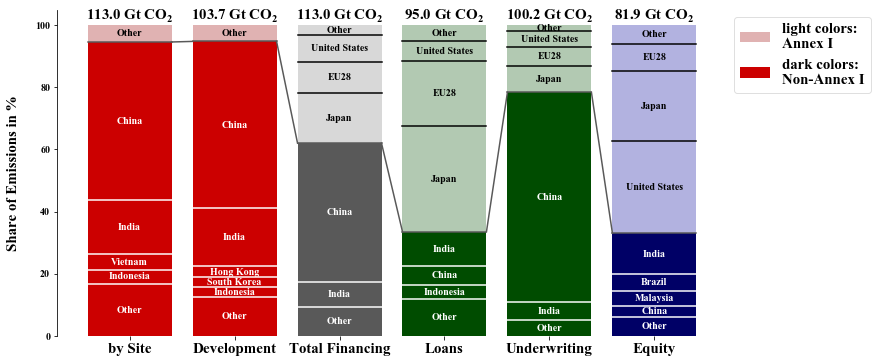

In [20]:
#plot graph with bars for each fin component, bars stacked non- & annex 1, share of total! 
##make lists for the color of the bars
list_color_light = [dict_colors['light red'], dict_colors['light red'], dict_colors['light grey'], \
                    dict_colors['light green'], dict_colors['light green'], dict_colors['light blue']]
list_color_dark = [dict_colors['dark red'], dict_colors['dark red'], dict_colors['dark grey'], \
                    dict_colors['dark green'], dict_colors['dark green'], dict_colors['dark blue']]

#set parameters
hfont = {'fontname':'Times New Roman'}
fs = 15

fig, ax1 = plt.subplots(figsize=(12,6))
#ax2 = ax1.twinx()

#plot stacked barplot
width = 0.8

ax1.bar(df_an_graph.index, df_an_graph['annex_1'], width, \
        color=list_color_light, bottom = df_an_graph['non_annex_1'], label='light colors:\nAnnex I')
ax1.bar(df_an_graph.index, df_an_graph['non_annex_1'], width, \
        color=list_color_dark, label='dark colors:\nNon-Annex I')

#remove spines
for x in ['top', 'bottom', 'right']: #left
    ax1.spines[x].set_visible(False)       

#set label
ax1.set_ylabel('Share of Emissions in %', fontsize=fs, labelpad=fs,**hfont)

#set legend
ax1.legend(loc="upper left", frameon=True, edgecolor= dict_colors['light grey'], fontsize=fs,\
           bbox_to_anchor=(1, 1),prop={'family':'Times New Roman','size':fs})

#set font of ticks
for tick in ax1.get_yticklabels():
    tick.set_fontname('Times New Roman')

    
x_tick_labels = ['by Site', 'Development', 'Total Financing', 'Loans', 'Underwriting', 'Equity']
#df_an_graph.index 
#ax1.set_xticks(np.arange(width/2, len(df_an_graph.index)+width/2, 1))
ax1.set_xticklabels(list(x_tick_labels), fontsize=fs,**hfont) #rotation=30, ha='right'

#make line connecting the bars
n = 0
df_an_graph_index = df_an_graph.reset_index()
for z in df_an_graph_index.index:
    ax1.plot((n-width/2,n+width/2),((df_an_graph_index.loc[z,'non_annex_1']),\
        (df_an_graph_index.loc[z,'non_annex_1'])), color=dict_colors['dark grey'])
    if z != df_an_graph_index.index.values[-1:]:
        ax1.plot((n+width/2,n+1-width/2), ((df_an_graph_index.loc[z,'non_annex_1']),\
        (df_an_graph_index.loc[z+1,'non_annex_1'])), color=dict_colors['dark grey'])
    n+=1

#SHOW BIGGEST COUNTRIES
##Non-AnnexI
n = 0
for x in dict_nonann.keys():
    for z in dict_nonann[x].index:
        ax1.annotate(dict_nonann[x].loc[z, 'FIN Country'], \
                     (n,((dict_nonann[x].loc[z, x]/2)+(dict_nonann[x].loc[z, x+'_sum']))) , \
                 fontsize=fs-5, color='w', ha='center', va='center', **hfont)   
        if z != dict_nonann[x].index.values[-1:]:
            ax1.plot((n-width/2,n+width/2), ((dict_nonann[x].loc[z, x+'_sum']),\
                                         (dict_nonann[x].loc[z, x+'_sum'])), color='w')
    n+=1
#AnnexI
n = 0
for x in dict_ann.keys():
    for z in dict_ann[x].index:
        ax1.annotate(dict_ann[x].loc[z, 'FIN Country'], \
                     (n,((dict_ann[x].loc[z, x]/2)+(dict_ann[x].loc[z, x+'_sum']))) , \
                 fontsize=fs-5, color='k', ha='center', va='center', **hfont)   
        if z != 0:
            ax1.plot((n-width/2,n+width/2), ((dict_ann[x].loc[z, x+'_sum']),\
                                         (dict_ann[x].loc[z, x+'_sum'])), color='k')
    n+=1

m=0
for x in ['site_em_Gt', 'dev_em_Gt', 'finv_em_Gt','loans_em_Gt', 'under_em_Gt', 'inv_em_Gt']:
    var_num = df_em_graph[x].sum().round(1)
    ax1.annotate((str(var_num)+' Gt '+'$\mathregular{CO_2}$'), (m,103), fontsize=fs, color='k', ha='center', va='center', **hfont)
    m+=1

#save graph
plt.savefig('.//for_paper//graphs//emissions_graph_\
dev_'+zd+'_fin_'+zf+'_inv_'+zi+'_for_'+str(var_min_share)+'_percent_EU28_'+timestr+'_V01.png', \
            bbox_inches="tight", dpi=600)

#plot graph
plt.show()

In [ ]:
#Development has less, because sometimes Developers country is unknown!